In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
# import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
# import MagellanicStream as ms

# ### Functions used in this code
# import age_functions as afunc

## Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

###
import linearfitting as linfit
import geometry as geo

import mlefitting as mlefit
import olsfitting as olsfit
import utilities as util

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
#######################
### Import SMC Data ###
#######################

#total number 1225
smc = fits.getdata('/Users/joshpovick/Research/SMC_Gradients/smc_rgbmembers.r13-l33-58932beta.fits.gz') 

cln = np.where((smc['FE_H']>-9999.0)&(smc['AK_TARG']>-9999.0)&(smc['LOGG']>0.0)&
               (smc['FE_H_ERR']>-90.0)&(smc['C_FE']>-9999.0)&(smc['N_FE']>-9999.0))

#total number 990
smc = smc[cln]

## Find Bloop
bloop = np.where((smc['H']<=13.25)&(smc['J']-smc['K']<=0.95)&(smc['TEFF']>=4175))
bloop_cut = []
for i in range(len(smc)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
smc_nobloop = smc[bloop_cut]

In [4]:
####################################
### Gaia Query Using Online Form ###
####################################

# (00:52:44, −72:49:42) Used in SMASH
center = SkyCoord('00:52:44 -72:49:42', unit=(u.hourangle, u.deg))

print('''Cone search center: {} with radius 6.5 deg'''.format(center))

smc_gaia = fits.getdata('smc_apogee-result.fits.gz')
cln = np.where((smc_gaia['astrometric_excess_noise']<1.0)&(np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&(np.isfinite(smc_gaia['phot_bp_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_rp_mean_mag'])==True)&(smc_gaia['parallax']<0.2)&
               (smc_gaia['parallax']>-0.2)&(smc_gaia['pmra']>=-3.0)&(smc_gaia['pmra']<=3.0)&
               (smc_gaia['pmdec']>=-3.0)&(smc_gaia['pmdec']<=3.0)&(smc_gaia['phot_g_mean_flux_over_error']>5.0)&
               (smc_gaia['phot_bp_mean_flux_over_error']>5.0)&(smc_gaia['phot_rp_mean_flux_over_error']>5.0))
smc_gaia = smc_gaia[cln]

# cuts from  

# @ARTICLE{2020MNRAS.tmp.3030O,
#        author = {{Omkumar}, Abinaya O. and {Subramanian}, Smitha and
#          {Niederhofer}, Florian and {Diaz}, Jonathan and {Cioni}, Maria-Rosa L. and
#          {El Youssoufi}, Dalal and {Bekki}, Kenji and {de Grijs}, Richard and
#          {van Loon}, Jacco Th},
#         title = "{Gaia view of a stellar sub-structure in front of the Small Magellanic Cloud}",
#       journal = {\mnras},
#      keywords = {Magellanic Clouds, galaxies: interactions, proper motions, stars: kinematics and dynamics, Astrophysics - Astrophysics of Galaxies},
#          year = 2020,
#         month = oct,
#           doi = {10.1093/mnras/staa3085},
# archivePrefix = {arXiv},
#        eprint = {2010.02687},
#  primaryClass = {astro-ph.GA},
#        adsurl = {https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.3030O},
#       adsnote = {Provided by the SAO/NASA Astrophysics Data System}
# }

Cone search center: <SkyCoord (ICRS): (ra, dec) in deg
    (13.18333333, -72.82833333)> with radius 6.5 deg


In [4]:
# Distance Modulus 18.99 +/- .10 

# @ARTICLE{2000A&A...359..601C,
#        author = {{Cioni}, M. -R.~L. and {van der Marel}, R.~P. and {Loup}, C. and
#          {Habing}, H.~J.},
#         title = "{The tip of the red giant branch and distance of the Magellanic Clouds: results from the DENIS survey}",
#       journal = {\aap},
#      keywords = {METHODS: STATISTICAL, STARS: EVOLUTION, GALAXIES: MAGELLANIC CLOUDS, GALAXIES: DISTANCES AND REDSHIFTS, Astrophysics},
#          year = 2000,
#         month = jul,
#        volume = {359},
#         pages = {601-614},
# archivePrefix = {arXiv},
#        eprint = {astro-ph/0003223},
#  primaryClass = {astro-ph},
#        adsurl = {https://ui.adsabs.harvard.edu/abs/2000A&A...359..601C},
#       adsnote = {Provided by the SAO/NASA Astrophysics Data System}
# }

In [5]:
#########################
### Import Isochrones ###
#########################

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/SMC_Gradients/parsec3_4.dat', \
                    format='basic', delimiter='\s')

parsec = parsecall[np.where(parsecall['label']==3)]

parsec9351010 = ascii.read('/Users/joshpovick/Desktop/Research/SMC_Gradients/parsec3_49351010.dat', \
                    format='basic', delimiter='\s')

In [6]:
#################
### Red Clump ###
#################

rc_cut = np.where((smc_gaia['bp_rp']>0.65)&(smc_gaia['bp_rp']<1.25)&(smc_gaia['phot_g_mean_mag']>18.8)
                  &(smc_gaia['phot_g_mean_mag']<19.7))
rc_gaia = smc_gaia[rc_cut]

In [7]:
################################
### Individual APOGEE Fields ###
################################

tuc47 = np.where(smc_nobloop['FIELD']=='47TUC')
tuc47 = smc_nobloop[tuc47]

n362 = np.where(smc_nobloop['FIELD']=='N362')
n362 = smc_nobloop[n362]

smc1 = np.where(smc_nobloop['FIELD']=='SMC1')
smc1 = smc_nobloop[smc1]

smc2 = np.where(smc_nobloop['FIELD']=='SMC2')
smc2 = smc_nobloop[smc2]

smc3 = np.where(smc_nobloop['FIELD']=='SMC3')
smc3 = smc[smc3]

smc4 = np.where(smc_nobloop['FIELD']=='SMC4')
smc4 = smc_nobloop[smc4]

smc5 = np.where(smc_nobloop['FIELD']=='SMC5')
smc5 = smc_nobloop[smc5]

smc6 = np.where(smc_nobloop['FIELD']=='SMC6')
smc6 = smc_nobloop[smc6]

smc7 = np.where(smc_nobloop['FIELD']=='SMC7')
smc7 = smc_nobloop[smc7]

In [8]:
##############################
### Individual Gaia Fields ###
##############################

def euclid(x,y,h,k):
    '''
    Calculate the distance from some point (h,k)
    
    Inputs:
    ------
        x: x coordinate(s) of point(s)
        y: y coordinate(s) of point(s)
        h: x coordinate of reference point
        k: y coordinate of reference point
    
    Output:
    ------
        r: distance between (x,y) and (h,k)
    '''
    
    r = np.sqrt(np.subtract(x,h)**2+np.subtract(y,k)**2)
    
    return r

gaia47 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(tuc47['RA']),np.median(tuc47['DEC']))<=0.95)]
gaia362 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(n362['RA']),np.median(n362['DEC']))<=0.95)]
gaia1 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc1['RA']),np.median(smc1['DEC']))<=0.95)]
gaia2 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc2['RA']),np.median(smc2['DEC']))<=0.95)]
gaia3 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc3['RA']),np.median(smc3['DEC']))<=0.95)]
gaia4 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc4['RA']),np.median(smc4['DEC']))<=0.95)]
gaia5 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc5['RA']),np.median(smc5['DEC']))<=0.95)]
gaia6 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc6['RA']),np.median(smc6['DEC']))<=0.95)]
gaia7 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc7['RA']),np.median(smc7['DEC']))<=0.95)]

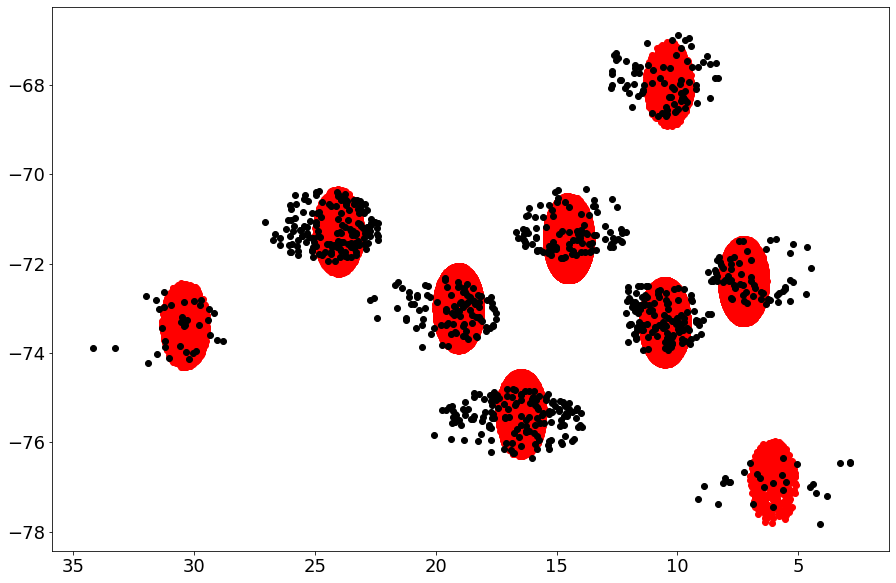

In [9]:
gaia_ras = [gaia47['ra'],gaia362['ra'],gaia1['ra'],gaia2['ra'],gaia3['ra'],gaia4['ra'],gaia5['ra'],gaia6['ra'],
            gaia7['ra']]
gaia_decs = [gaia47['dec'],gaia362['dec'],gaia1['dec'],gaia2['dec'],gaia3['dec'],gaia4['dec'],gaia5['dec'],
             gaia6['dec'],gaia7['dec']]
smc_ras = [tuc47['ra'],n362['ra'],smc1['ra'],smc2['ra'],smc3['ra'],smc4['ra'],smc5['ra'],smc6['ra'],
            smc7['ra']]
smc_decs = [tuc47['dec'],n362['dec'],smc1['dec'],smc2['dec'],smc3['dec'],smc4['dec'],smc5['dec'],
             smc6['dec'],smc7['dec']]
# smc_col = [8.*np.ones(len(smc_ras[0])),9.*np.ones(len(smc_ras[1])),1.*np.ones(len(smc_ras[2])),
#            2.*np.ones(len(smc_ras[3])),3.*np.ones(len(smc_ras[4])),4.*np.ones(len(smc_ras[5])),
#            5.*np.ones(len(smc_ras[6])),6.*np.ones(len(smc_ras[7])),7.*np.ones(len(smc_ras[8]))]

plt.figure(figsize=[15,10])
for i in range(len(gaia_ras)):
    plt.scatter(gaia_ras[i],gaia_decs[i],c='r',zorder=1)
    plt.scatter(smc_ras[i],smc_decs[i],c='k',zorder=2)

plt.gca().invert_xaxis()
plt.show()

<font size='45'>
    <b>
        CMD
    </b>
</font>

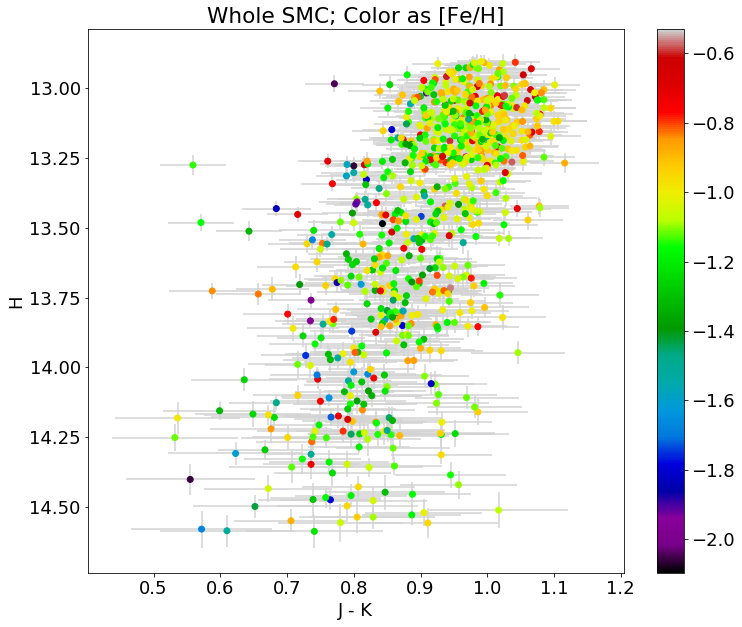

In [10]:
col_err = np.sqrt(smc_nobloop['J_ERR']**2+smc_nobloop['K_ERR']**2)

plt.figure(figsize=[12,10])
plt.errorbar(smc_nobloop['J']-smc_nobloop['K'],smc_nobloop['H'],yerr=smc_nobloop['H_ERR'],xerr=col_err,
             c='lightgray',zorder=1,ls='none')
plt.scatter(smc_nobloop['J']-smc_nobloop['K'],smc_nobloop['H'],c=smc_nobloop['FE_H'],
            cmap='nipy_spectral',zorder=2)
plt.colorbar()
plt.gca().invert_yaxis()

plt.title(r'Whole SMC; Color as [Fe/H]')
plt.xlabel(r'J - K')
plt.ylabel(r'H')

plt.show()

In [11]:
### List of Fields
fields = ['47 TUC', 'NGC 362', 'SMC1', 'SMC2', 'SMC3', 'SMC4', 'SMC5', 'SMC6', 'SMC7']

### List of J-K color for each field
fieldcols = [tuc47['J']-tuc47['K'],n362['J']-n362['K'],smc1['J']-smc1['K'],smc2['J']-smc2['K'],
             smc3['J']-smc3['K'],smc4['J']-smc4['K'],smc5['J']-smc5['K'],smc6['J']-smc6['K'],smc7['J']-smc7['K']]
fieldcols_err = [np.sqrt(tuc47['J_ERR']**2+tuc47['K_ERR']**2),np.sqrt(n362['J_ERR']**2+n362['K_ERR']**2),
                 np.sqrt(smc1['J_ERR']**2+smc1['K_ERR']**2),np.sqrt(smc2['J_ERR']**2+smc2['K_ERR']**2),
                 np.sqrt(smc3['J_ERR']**2+smc3['K_ERR']**2),np.sqrt(smc4['J_ERR']**2+smc4['K_ERR']**2),
                 np.sqrt(smc5['J_ERR']**2+smc5['K_ERR']**2),np.sqrt(smc6['J_ERR']**2+smc6['K_ERR']**2),
                 np.sqrt(smc7['J_ERR']**2+smc7['K_ERR']**2)]

### List of H for each field
fieldh = [tuc47['H'],n362['H'],smc1['H'],smc2['H'],smc3['H'],smc4['H'],smc5['H'],smc6['H'],smc7['H']]
fieldh_err = [tuc47['H_ERR'],n362['H_ERR'],smc1['H_ERR'],smc2['H_ERR'],smc3['H_ERR'],smc4['H_ERR'],smc5['H_ERR'],
              smc6['H_ERR'],smc7['H_ERR']]

### List of Metallicities
fieldfeh = [tuc47['FE_H'],n362['FE_H'],smc1['FE_H'],smc2['FE_H'],smc3['FE_H'],smc4['FE_H'],smc5['FE_H'],
            smc6['FE_H'],smc7['FE_H']]

### List of Gaia G mag for each field
fieldg = [tuc47['GAIA_GMAG'],n362['GAIA_GMAG'],smc1['GAIA_GMAG'],smc2['GAIA_GMAG'],smc3['GAIA_GMAG'],
          smc4['GAIA_GMAG'],smc5['GAIA_GMAG'],smc6['GAIA_GMAG'],smc7['GAIA_GMAG']]

### List of Gaia BP - RP Color
fieldgcols = [tuc47['GAIA_BPMAG']-tuc47['GAIA_RPMAG'],n362['GAIA_BPMAG']-n362['GAIA_RPMAG'],
             smc1['GAIA_BPMAG']-smc1['GAIA_RPMAG'],smc2['GAIA_BPMAG']-smc2['GAIA_RPMAG'],
             smc3['GAIA_BPMAG']-smc3['GAIA_RPMAG'],smc4['GAIA_BPMAG']-smc4['GAIA_RPMAG'],
             smc5['GAIA_BPMAG']-smc5['GAIA_RPMAG'],smc6['GAIA_BPMAG']-smc6['GAIA_RPMAG'],
             smc7['GAIA_BPMAG']-smc7['GAIA_RPMAG']]


############
### GAIA ###
############

### List of J-K color for each field
field_bprp = [gaia47['bp_rp'],gaia362['bp_rp'],gaia1['bp_rp'],gaia2['bp_rp'],gaia3['bp_rp'],gaia4['bp_rp'],
              gaia5['bp_rp'],gaia6['bp_rp'],gaia7['bp_rp']]

### List of H for each field
field_g = [gaia47['phot_g_mean_mag'],gaia362['phot_g_mean_mag'],gaia1['phot_g_mean_mag'],gaia2['phot_g_mean_mag'],
           gaia3['phot_g_mean_mag'],gaia4['phot_g_mean_mag'],gaia5['phot_g_mean_mag'],gaia6['phot_g_mean_mag'],
           gaia7['phot_g_mean_mag']]

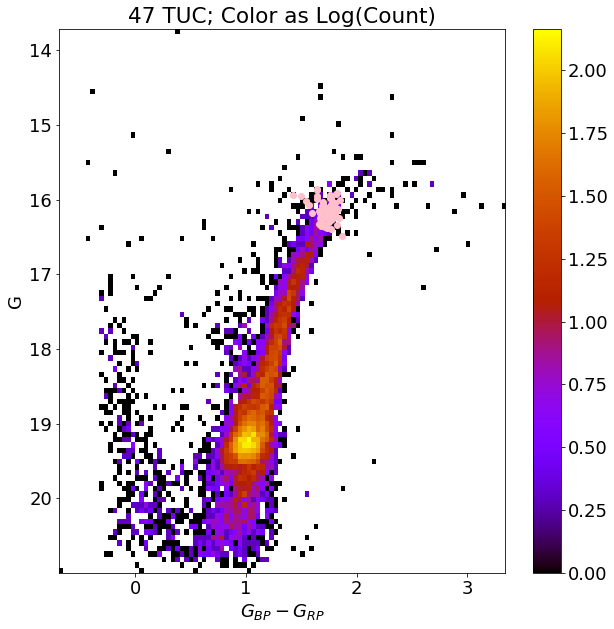

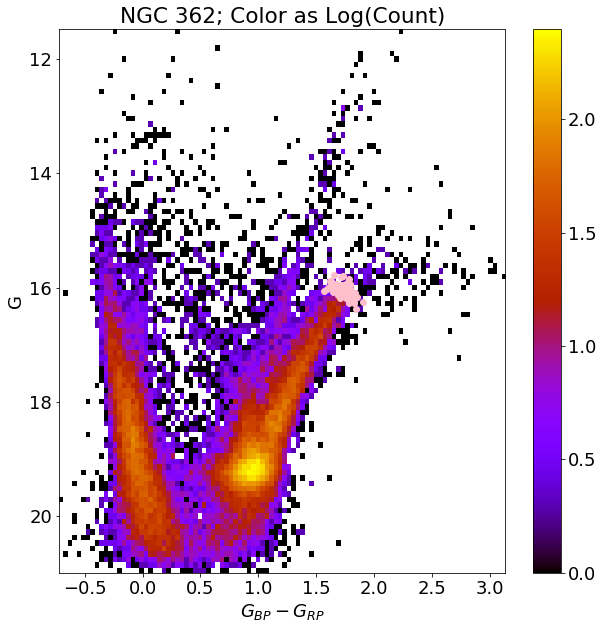

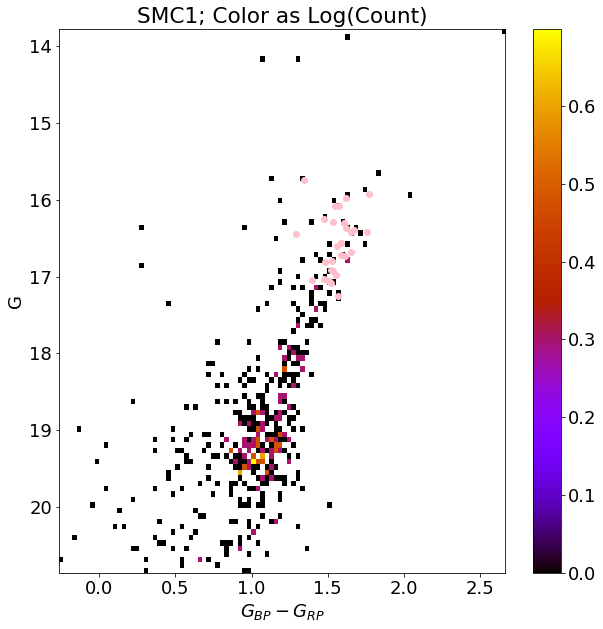

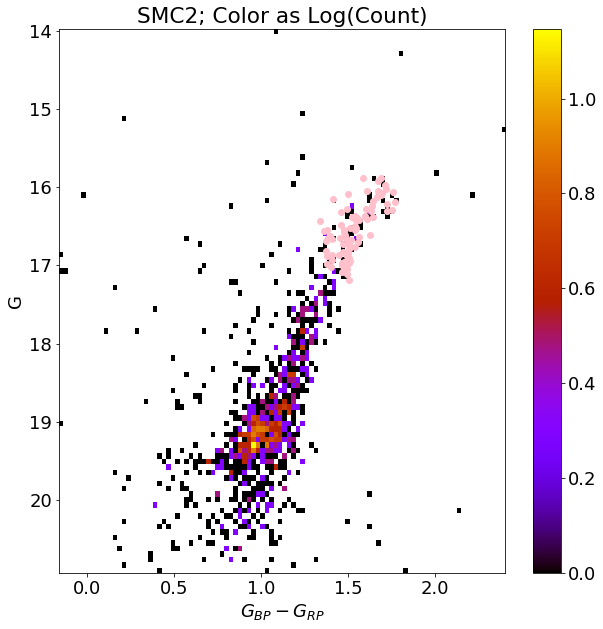

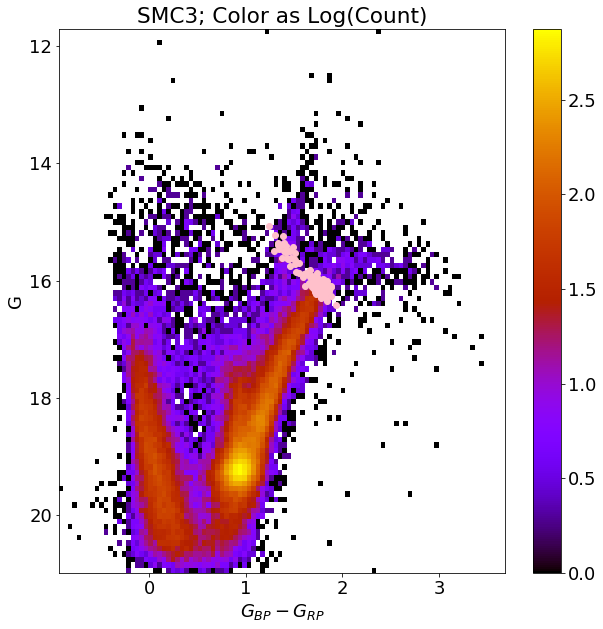

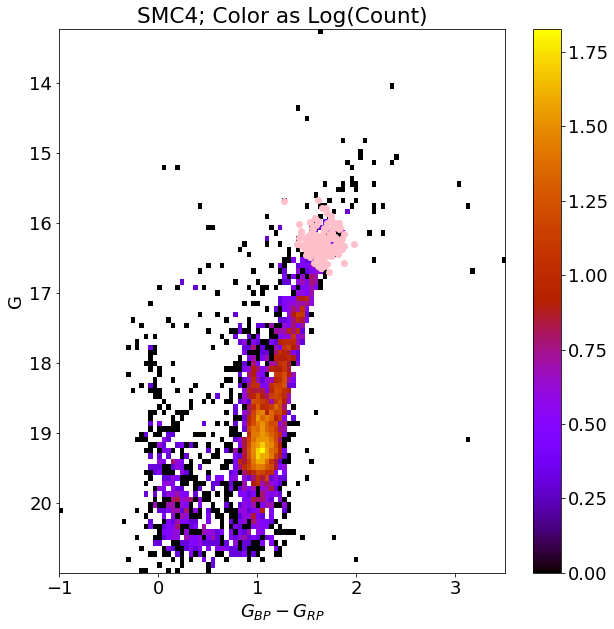

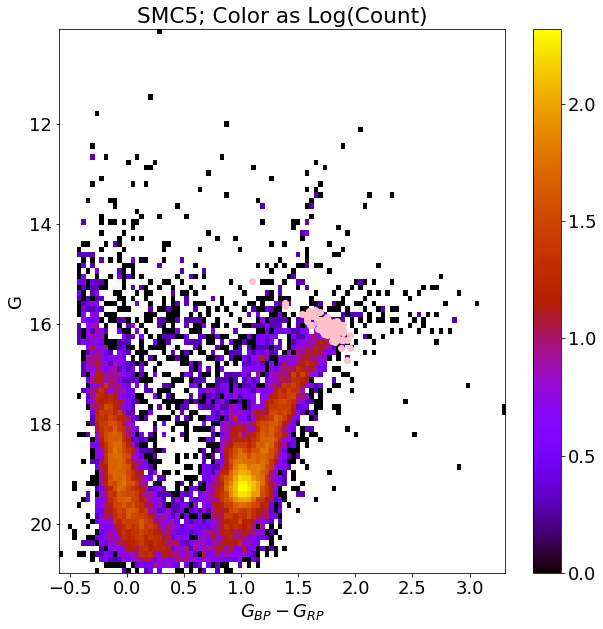

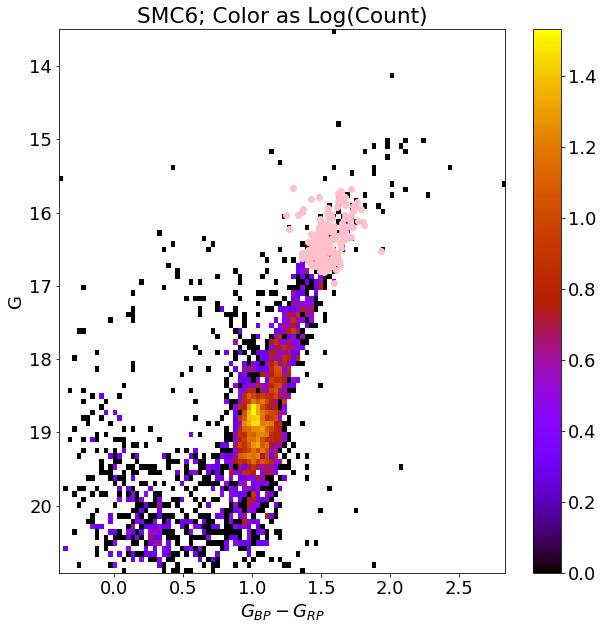

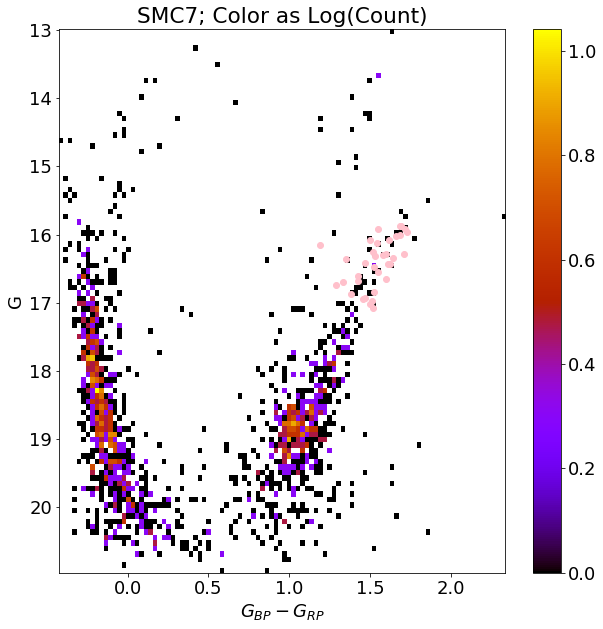

In [12]:
###############################
### Plot Field by Field CMD ###
###############################

# ### 2MASS
# for i in range(len(fieldcols)):
#     plt.figure(figsize=[12,10])
#     plt.errorbar(fieldcols[i],fieldh[i],xerr=fieldcols_err[i],yerr=fieldh_err[i],
#                  c='lightgray',zorder=1,ls='none')
#     plt.scatter(fieldcols[i],fieldh[i],c=fieldfeh[i],cmap='nipy_spectral',zorder=2)
#     plt.colorbar()
#     plt.gca().invert_yaxis()

#     plt.title(r'{}; Color as Proper Motion'.format(fields[i]))
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'H')

#     plt.show()
    
# ### GAIA
# for i in range(len(fieldcols)):
#     plt.figure(figsize=[12,10])
#     plt.scatter(fieldgcols[i],fieldg[i],c=fieldfeh[i],cmap='nipy_spectral',
#                 zorder=2)
#     plt.colorbar()
#     plt.gca().invert_yaxis()

#     plt.title(r'{}; Color as [Fe/H]'.format(fields[i]))
#     plt.xlabel(r'$G_{BP} - G_{RP}$')
#     plt.ylabel(r'G')

#     plt.show()

### SMC GAIA and APOGEE
from scipy.stats import binned_statistic_2d

fieldfilename = ['47tuc','n362','smc1','smc2','smc3','smc4','smc5','smc6','smc7']

for i in range(len(fieldcols)):
    
    N = binned_statistic_2d(x=field_bprp[i],y=field_g[i],values=field_bprp[i],statistic='count',bins=100)
    
    plt.figure(figsize=[10,10])
    
    im = plt.imshow(np.log10(N.statistic.T),origin='lower',
           extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
    
    plt.scatter(fieldgcols[i],fieldg[i],c='pink',cmap='nipy_spectral',zorder=2)
    
    plt.colorbar(im)
    plt.gca().invert_yaxis()

    plt.title(r'{}; Color as Log(Count)'.format(fields[i]))
    plt.xlabel(r'$G_{BP} - G_{RP}$')
    plt.ylabel(r'G')

    plt.savefig('gaia{}'.format(fieldfilename[i]),bbox_inches='tight')
    plt.show()

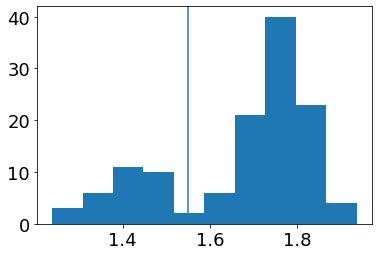

In [13]:
plt.hist(smc3['GAIA_BPMAG']-smc3['GAIA_RPMAG'])
plt.axvline(1.55)

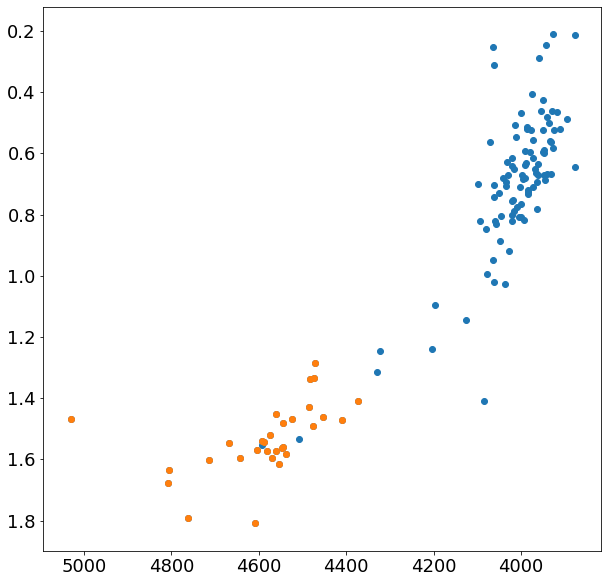

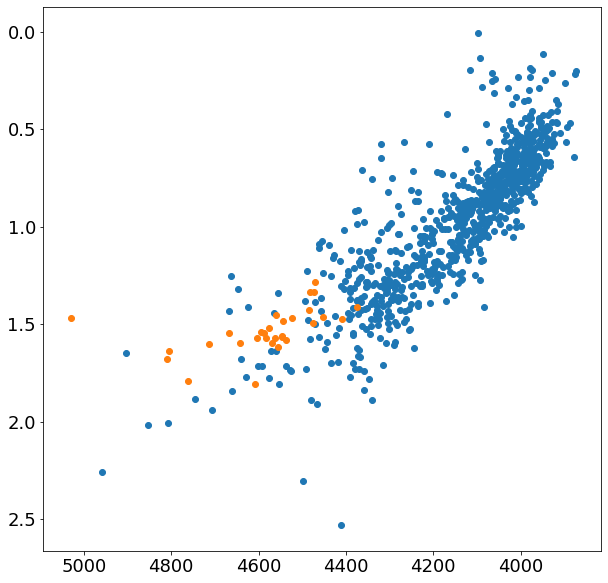

In [14]:
weird = np.where((smc3['GAIA_BPMAG']-smc3['GAIA_RPMAG'])<1.55)

plt.figure(figsize=[10,10])
plt.scatter(smc3['TEFF'],smc3['LOGG'])
plt.scatter(smc3['TEFF'][weird],smc3['LOGG'][weird])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(smc_nobloop['TEFF'],smc_nobloop['LOGG'])
plt.scatter(smc3['TEFF'][weird],smc3['LOGG'][weird])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

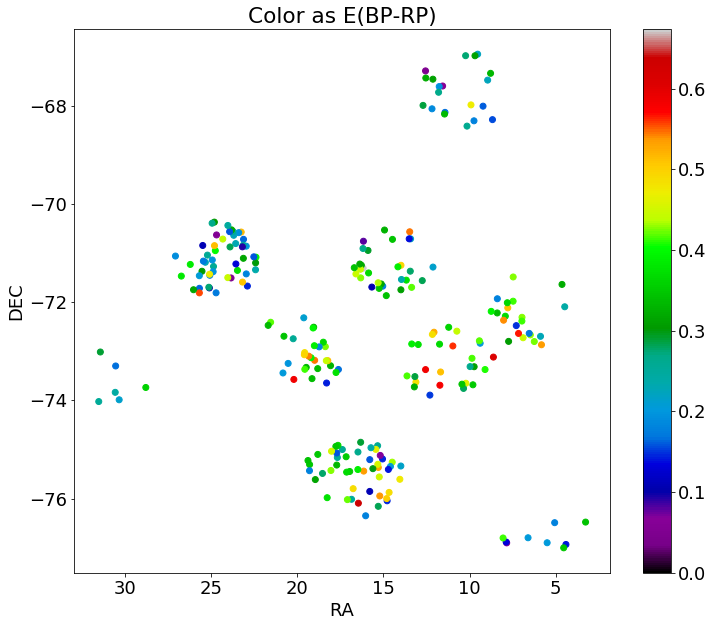

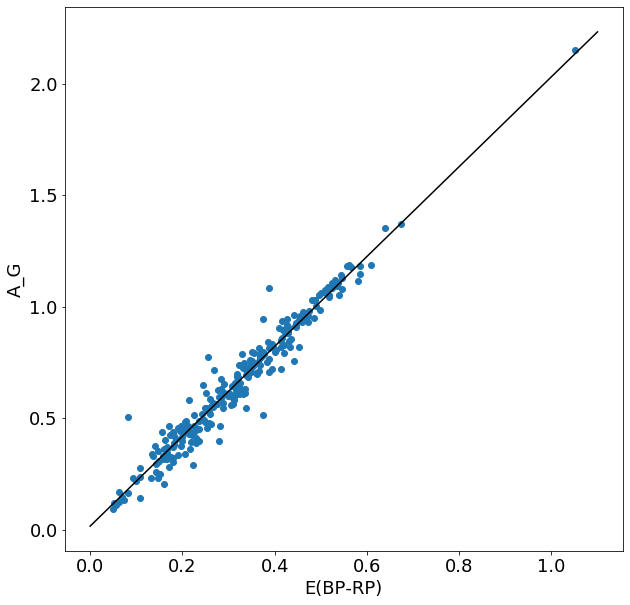

A_G = m*E(BP-RP) + b:   
2.014 x + 0.0177
   
47 TUC E(BP-RP): 0.40415 fit A_G: 0.83155 Med A_G: 0.80465
NGC 362 E(BP-RP): 0.32750 fit A_G: 0.67720 Med A_G: 0.70150
SMC1 E(BP-RP): 0.20470 fit A_G: 0.42991 Med A_G: 0.37670
SMC2 E(BP-RP): 0.24315 fit A_G: 0.50734 Med A_G: 0.47060
SMC3 E(BP-RP): 0.36770 fit A_G: 0.75815 Med A_G: 0.75550
SMC4 E(BP-RP): 0.34550 fit A_G: 0.71344 Med A_G: 0.68000
SMC5 E(BP-RP): 0.36830 fit A_G: 0.75936 Med A_G: 0.77850
SMC6 E(BP-RP): 0.24900 fit A_G: 0.51912 Med A_G: 0.48850
SMC7 E(BP-RP): 0.24915 fit A_G: 0.51942 Med A_G: 0.61650


In [15]:
###############################
### Determine Reddening Law ###
###############################

goode = np.where(smc_nobloop['GAIA_A_G_VAL']!=-9999.0)
plt.figure(figsize=[12,10])

plt.scatter(smc_nobloop['RA'][goode],smc_nobloop['DEC'][goode],c=smc_nobloop['GAIA_E_BP_MIN_RP_VAL'][goode],
            vmin=0,cmap='nipy_spectral')

plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Color as E(BP-RP)')
plt.show()

### APOGEE (GAIA)
z = np.polyfit(smc[np.where(smc['GAIA_A_G_VAL']!=-9999.0)]['GAIA_E_BP_MIN_RP_VAL'], 
               smc[np.where(smc['GAIA_A_G_VAL']!=-9999.0)]['GAIA_A_G_VAL'], 1)
p = np.poly1d(z)

plt.figure(figsize=[10,10])
plt.scatter(smc[np.where(smc['GAIA_E_BP_MIN_RP_VAL']!=-9999.0)]['GAIA_E_BP_MIN_RP_VAL'],
           smc[np.where(smc['GAIA_A_G_VAL']!=-9999.0)]['GAIA_A_G_VAL'])
plt.plot([0,1.1],p([0,1.1]),c='k')
plt.xlabel('E(BP-RP)')
plt.ylabel('A_G')
plt.show()

print('A_G = m*E(BP-RP) + b: ',p)
print('   ')

flist = [tuc47,n362,smc1,smc2,smc3,smc4,smc5,smc6,smc7]

field_red = []
field_ext = []
field_ag = []
field_ag_dev = []
for i in range(len(flist)):
    cln = np.where(flist[i]['GAIA_E_BP_MIN_RP_VAL']!=-9999.0)
    field_red.append(np.median(flist[i]['GAIA_E_BP_MIN_RP_VAL'][cln]))
    field_ext.append(p(np.median(flist[i]['GAIA_E_BP_MIN_RP_VAL'][cln])))
    print('{} E(BP-RP): {:.5f} fit A_G: {:.5f} Med A_G: {:.5f}'.format(fields[i],
                                                np.median(flist[i]['GAIA_E_BP_MIN_RP_VAL'][cln]),
                                                p(np.median(flist[i]['GAIA_E_BP_MIN_RP_VAL'][cln])),
                                                np.median(flist[i]['GAIA_A_G_VAL'][cln])))
    
    field_ag.append(np.median(flist[i]['GAIA_A_G_VAL'][cln]))
    field_ag_dev.append(util.mad(flist[i]['GAIA_A_G_VAL'][cln]))

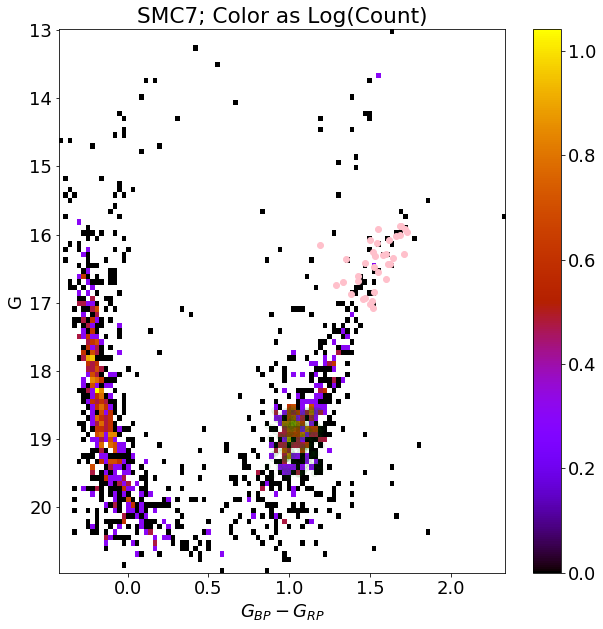

In [16]:
i = 8
box = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.85)&(field_g[i]<19.55)&(field_g[i]>18.55))
N = binned_statistic_2d(x=field_bprp[i],y=field_g[i],values=field_bprp[i],statistic='count',bins=100)
    
plt.figure(figsize=[10,10])
    
im = plt.imshow(np.log10(N.statistic.T),origin='lower',
                extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
                interpolation='nearest',cmap='gnuplot')
    
plt.scatter(fieldgcols[i],fieldg[i],c='pink',cmap='nipy_spectral',zorder=2)

plt.scatter(field_bprp[i][box],field_g[i][box],c='green',zorder=3,alpha=0.05)
    
plt.colorbar(im)
plt.gca().invert_yaxis()

plt.title(r'{}; Color as Log(Count)'.format(fields[i]))
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'G')

plt.show()

In [17]:
##########################
### RC Selection Boxes ###
##########################

box47 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.8)&(field_g[i]<19.55)&(field_g[i]>18.9))
box362 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.6)&(field_g[i]<19.65)&(field_g[i]>18.7))
box1 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.85)&(field_g[i]<19.55)&(field_g[i]>18.8))
box2 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.9)&(field_g[i]<19.55)&(field_g[i]>18.8))
box3 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.65)&(field_g[i]<19.55)&(field_g[i]>18.8))
box4 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.7)&(field_g[i]<19.6)&(field_g[i]>18.75))
box5 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.85)&(field_g[i]<19.6)&(field_g[i]>18.75))
box6 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.85)&(field_g[i]<19.55)&(field_g[i]>18.55))
box7 = np.where((field_bprp[i]<1.2)&(field_bprp[i]>0.85)&(field_g[i]<19.55)&(field_g[i]>18.55))

boxes = [box47,box362,box1,box2,box3,box4,box5,box6,box7]

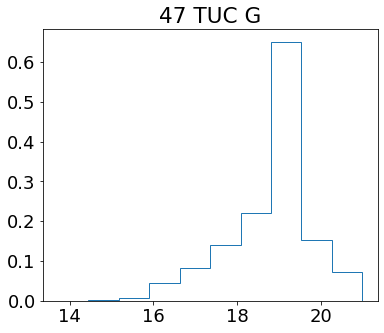

Median: 19.1171, MAD: 0.4121


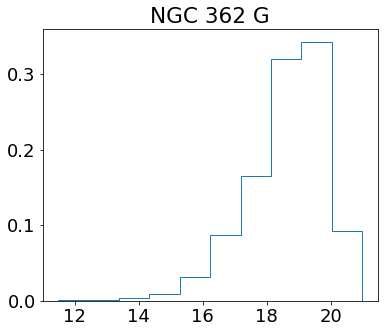

Median: 18.9033, MAD: 0.6340


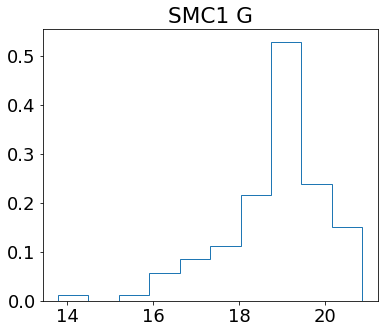

Median: 19.1137, MAD: 0.5472


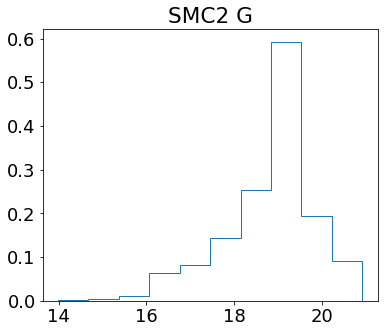

Median: 19.0666, MAD: 0.5011


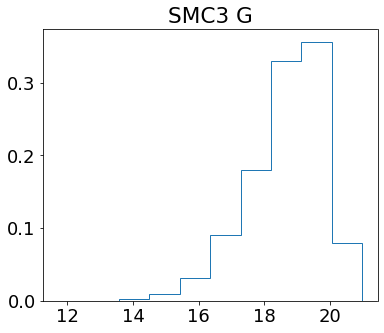

Median: 18.9396, MAD: 0.5890


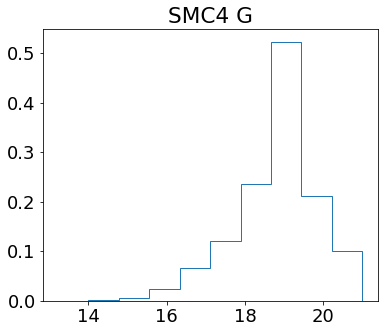

Median: 19.0112, MAD: 0.5266


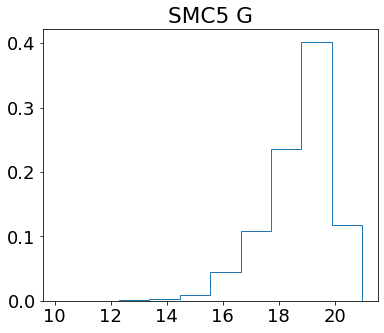

Median: 18.9780, MAD: 0.6248


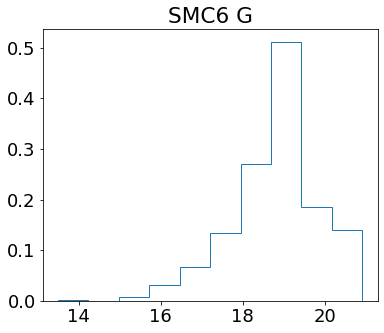

Median: 18.8879, MAD: 0.5423


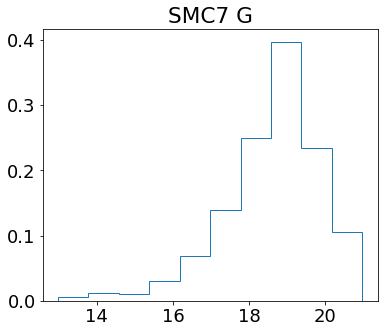

Median: 18.7853, MAD: 0.7288


In [18]:
rc_mag = []
rc_dev = []
for i in range(len(boxes)):
    cln = np.where(np.isfinite(field_g[i])==True)
    
    plt.figure(figsize=[6,5])
    plt.hist(field_g[i][cln],histtype='step',density=True)
    plt.title(r'{} G'.format(fields[i]))
    plt.show()
    
    me = np.median(field_g[i][cln])
    ma = util.mad(field_g[i][cln])
    rc_mag.append(me)
    rc_dev.append(ma)
    print(r'Median: {:.4f}, MAD: {:.4f}'.format(me,ma))

In [20]:
field_ag

[0.80465, 0.7015, 0.3767, 0.4706, 0.7555, 0.68, 0.7785, 0.4885, 0.6165]

In [22]:
10**((np.asarray(rc_mag)-0.44)/5.+1)

array([54377.086, 49279.363, 54291.895, 53127.617, 50109.79 , 51789.36 ,
       51004.41 , 48931.234, 46672.82 ], dtype=float32)

In [31]:
10**((np.asarray(rc_mag)-0.44)/5.+1)+8995.58984375

array([63372.676, 58274.953, 63287.484, 62123.207, 59105.38 , 60784.95 ,
       60000.   , 57926.824, 55668.41 ], dtype=float32)

In [26]:
60000-np.median(10**((np.asarray(rc_mag)-0.44)/5.+1))

8995.58984375

In [27]:
np.asarray(rc_mag)-18.99#+np.asarray(field_ag)

array([ 0.12708092, -0.08667374,  0.1236763 ,  0.07660294, -0.05038643,
        0.02120399, -0.01196098, -0.10206795, -0.20467949], dtype=float32)

In [34]:
#distance modulus of smc at 60 kpc
mod60 = 5*np.log10(60000)-5

#calculate median absolute magnitude using 
med_abs = np.median(np.asarray(rc_mag)-mod60)

In [35]:
abs_dist = 10**((np.asarray(rc_mag)-med_abs)/5.+1)
# abs_dist_err = 10**((np.asarray(rc_mag)-med_abs)/5.+1)

array([63967.547, 57970.742, 63867.332, 62497.71 , 58947.63 , 60923.426,
       60000.035, 57561.21 , 54904.484], dtype=float32)

In [22]:
###########################
### Closest Metallicity ###
###########################

smcFE_H = [tuc47['FE_H'],n362['FE_H'],smc1['FE_H'],smc2['FE_H'],smc3['FE_H'],smc4['FE_H'],smc5['FE_H'],
           smc6['FE_H'],smc7['FE_H']]

def near(arr,val):
    '''
    Find the element value of arr closest to the given value
    
    Inputs:
    ------
        arr: array-like object to search
        val: value of interest
        
    Output:
    ------
        out: value in arr closest to the given value (val) 
    '''
    uniq_arr = np.unique(arr)
    idx = np.absolute(uniq_arr-(val)*np.ones(len(uniq_arr))).argmin()
    out = uniq_arr[idx] 
    return out

cl_feh = []
for i in range(len(smcFE_H)):
    cl_feh.append(near(parsec['MH'],np.median(smcFE_H[i])))
    
tot_cl_feh = near(parsec['MH'],np.median(smc_nobloop['FE_H']))

for i in range(9):
    print('{} [Fe/H]: {:.7f} PARSEC: {}'.format(fields[i],np.median(smcFE_H[i]),cl_feh[i]))
    
print('-----')
print('Overall [Fe/H]: {:.7f} PARSEC: {}'.format(np.median(smc_nobloop['FE_H']),tot_cl_feh))

47 TUC [Fe/H]: -1.0650616 PARSEC: -1.05
NGC 362 [Fe/H]: -1.0249616 PARSEC: -1.0
SMC1 [Fe/H]: -1.0770116 PARSEC: -1.1
SMC2 [Fe/H]: -1.1810615 PARSEC: -1.2
SMC3 [Fe/H]: -0.8970466 PARSEC: -0.9
SMC4 [Fe/H]: -1.1073616 PARSEC: -1.1
SMC5 [Fe/H]: -1.0132616 PARSEC: -1.0
SMC6 [Fe/H]: -1.0496116 PARSEC: -1.05
SMC7 [Fe/H]: -1.1504616 PARSEC: -1.15
-----
Overall [Fe/H]: -1.0606616 PARSEC: -1.05


[0.8315482867511924,
 0.6771951872208615,
 0.4299081203885862,
 0.5073363692158752,
 0.7581475229882909,
 0.7134424927862653,
 0.7593557264977493,
 0.5191167435246314,
 0.5194188244090373]

In [36]:
def find_ages(z1,z2,z3):
#good good
    # #     x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu
#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3))
    
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
    p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))

    return age

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def sal(MH,aM):
    '''
    Calculate the Salaris correction to the overall metallicity
    '''
    return MH + np.log(0.638*(10**(aM))+0.362)

In [37]:
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

#distance modulus of smc at 60 kpc
mod60 = 5*np.log10(60000)-5

#calculate median absolute magnitude using 
med_abs = np.median(np.asarray(rc_mag)-mod60)

abs_dist = 10**((np.asarray(rc_mag)-med_abs)/5.+1)

In [ ]:
### PCA
from sklearn.decomposition import PCA, KernelPCA

age_dist = []
age_dist_nopm = []

data = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T
pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(smc_nobloop)),desc='Done?'):
    
    # temperature
    teff = smc_nobloop['TEFF'][i]
    teff_err = smc_nobloop['TEFF_ERR'][i]
    
    # photometry 
    ra = smc_nobloop['RA'][i]
    dec = smc_nobloop['DEC'][i]
    ks = smc_nobloop['K'][i]
    ks_err = smc_nobloop['K_ERR'][i]
    ak = smc_nobloop['AK_TARG'][i]
    
    if smc_nobloop['FIELD'] == '47TUC':
        distance = abs_dist[0]
        distance_err = 
    if smc_nobloop['FIELD'] == 'N362':
        distance = abs_dist[1]
        distance_err = 
    if smc_nobloop['FIELD'] == 'SMC1':
        distance = abs_dist[2]
        distance_err = 
    if smc_nobloop['FIELD'] == 'SMC2':
        distance = abs_dist[3]
        distance_err = 
    if smc_nobloop['FIELD'] == 'SMC3':
        distance = abs_dist[4]
        distance_err = 
    if smc_nobloop['FIELD'] == 'SMC4':
        distance = abs_dist[5]
        distance_err = 
    if smc_nobloop['FIELD'] == 'SMC5':
        distance = abs_dist[6]
        distance_err = 
    if smc_nobloop['FIELD'] == 'SMC6':
        distance = abs_dist[7]
        distance_err = 
    if smc_nobloop['FIELD'] == 'SMC7':
        distance = abs_dist[8]
        distance_err = 
        
#     distance = dis[i]/1000.
#     distance_err = dis_err[i]/1000.
#     distance_nopm = dis_nopm[i]/1000.
#     distance_nopm_err = dis_nopm_err[i]/1000.
    
    # abundances
    mh = smc_nobloop['M_H'][i]
    mh_err = smc_nobloop['M_H_ERR'][i]
    cfe = smc_nobloop['C_FE'][i]
    cfe_err = smc_nobloop['C_FE_ERR'][i]
    nfe = smc_nobloop['N_FE'][i]
    nfe_err = smc_nobloop['N_FE_ERR'][i]
    feh = smc_nobloop['FE_H'][i]
    feh_err = smc_nobloop['FE_H_ERR'][i]
    
    # surface gravity
    lgg = smc_nobloop['LOGG'][i]
    lgg_err = smc_nobloop['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    noise_ages_nopm = []
    new_nopm = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = util.add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
#         _, _, dist = afunc.LMCdisk_cart(ra,dec)

        dist_new = util.add_noise(distance,distance_err)
#         dist_new_nopm = util.add_noise(distance_nopm,distance_nopm_err)
        
        ks_new = util.add_noise(ks,ks_err)
            
        absK_new = absmag(ks_new,dist_new) - ak
#         absK_new_nopm = absmag(ks_new,dist_new_nopm) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(util.add_noise(cfe,cfe_err)+
                                 util.add_noise(feh,feh_err)-util.add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(util.add_noise(nfe,nfe_err)+
                                 util.add_noise(feh,feh_err)-util.add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = util.add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = util.add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,sal(mh_new,ffac_new),lgg_new]))
#         new_nopm.append(np.array([lgteff_new,absK_new_nopm,sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))
    zs_nopm = pca_transform.transform(np.asarray(np.squeeze(new_nopm)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
#         noise_ages_nopm.append(find_ages(zs_nopm[l][0],zs_nopm[l][1],zs_nopm[l][2]))
    
    age_dist.append(noise_ages)
#     age_dist_nopm.append(noise_ages_nopm)

parages = [] 
devs = []
# parages_nopm = [] 
# devs_nopm = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(util.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
#     devs_nopm.append(util.mad(age_dist_nopm[k]))
#     parages_nopm.append(np.median(age_dist_nopm[k]))
    
devs = np.asarray(devs)
parages = np.asarray(parages)
# devs_nopm = np.asarray(devs_nopm)
# parages_nopm = np.asarray(parages_nopm)